Cerco di capire sta cosa dei J che vengono imparati subito ma con slope sbagliata, e poi si aggiustano

In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
L, q = 15, 3

In [8]:
h = torch.zeros(L, q)
J_ = utils.rand_coupling_matrix(L, q)
potts = energy_models.Potts(J_, h).set_zerosum_gauge()
# J = J_ * potts.mask

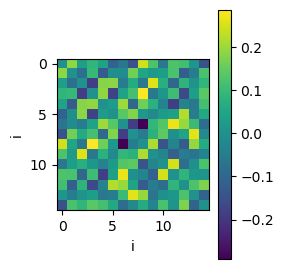

In [9]:
pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

In [10]:
compute_energy = lambda x : potts.compute_energy(x).item()
wt_oh = one_hot(torch.randint(q, (L,)))

In [11]:
E = utils.epistasis(compute_energy, wt_oh)

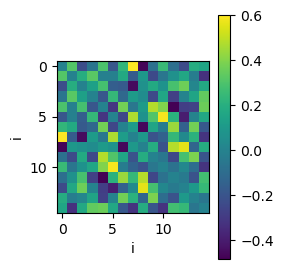

In [12]:
pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(E)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()